<a href="https://colab.research.google.com/github/clphan/k8s-resource-recommendations-system/blob/master/windows_data_for_validation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Mục đích của việc này dùng để xây dựng một list những giá trị mà nó là sự chuyển biến giữa các n*10, ví dụ 9800 và 10021 hoặc 19010 và 21000. Gía trị đó sẽ là khoảng thời gian mà hệ thống sẽ trigger để thực hiện việc scaling. Do đó, dễ dàng hơn trong việc đánh giá vì learning trong trường hợp này là đã train do đó không cần phải chạy hệ thống trên toàn thời gian mưới đánh giá được.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
# Load the data into a Pandas dataframe
df = pd.read_csv('/content/drive/MyDrive/thesis/processed-data/wc_dataset_processed_noise_removed.csv') #, usecols=[1, 2, 3])
# df.head(), df.shape
df.head(20)

,event_time,event_count,sum_bytes,num_match_event
0,1998-04-30 21:30:00,1,24736,0
1,1998-04-30 21:31:00,11,83086,0
2,1998-04-30 21:32:00,16,87949,0
3,1998-04-30 21:33:00,7,149401,0
4,1998-04-30 21:34:00,3,50457,0
5,1998-04-30 21:35:00,2,49472,0
6,1998-04-30 21:36:00,3,74208,0
7,1998-04-30 21:37:00,4,98944,0
8,1998-04-30 21:38:00,5,99929,0
9,1998-04-30 21:39:00,9,174327,0


In [ ]:
def  plot_data(df_plot):
  df_plot['event_time'] = pd.to_datetime(df_plot['event_time'])
  # Show the plot event_count
  fig = plt.figure(figsize=(30, 20))
  ax1 = fig.add_subplot(2, 2, 1)  # Top left
  ax2 = fig.add_subplot(2, 2, 2)  # Top right

  ax1.plot(color='red', marker='o', markerfacecolor='blue')
  ax1.plot(df_plot['event_time'], df_plot['event_count'], label='Event Count')#, color='blue')
  # ax1.set_title('Event Count vs Time')
  ax1.legend()
  # Show the plot num_bytes_response
  ax2.plot(color='red', marker='o', markerfacecolor='orange')
  ax2.plot(df_plot['event_time'], df_plot['sum_bytes'], label='Sum Bytes Response')#,  color='green')
  # ax2.set_title('Sum Bytes Response vs Time')
  ax2.legend()
  plt.show()

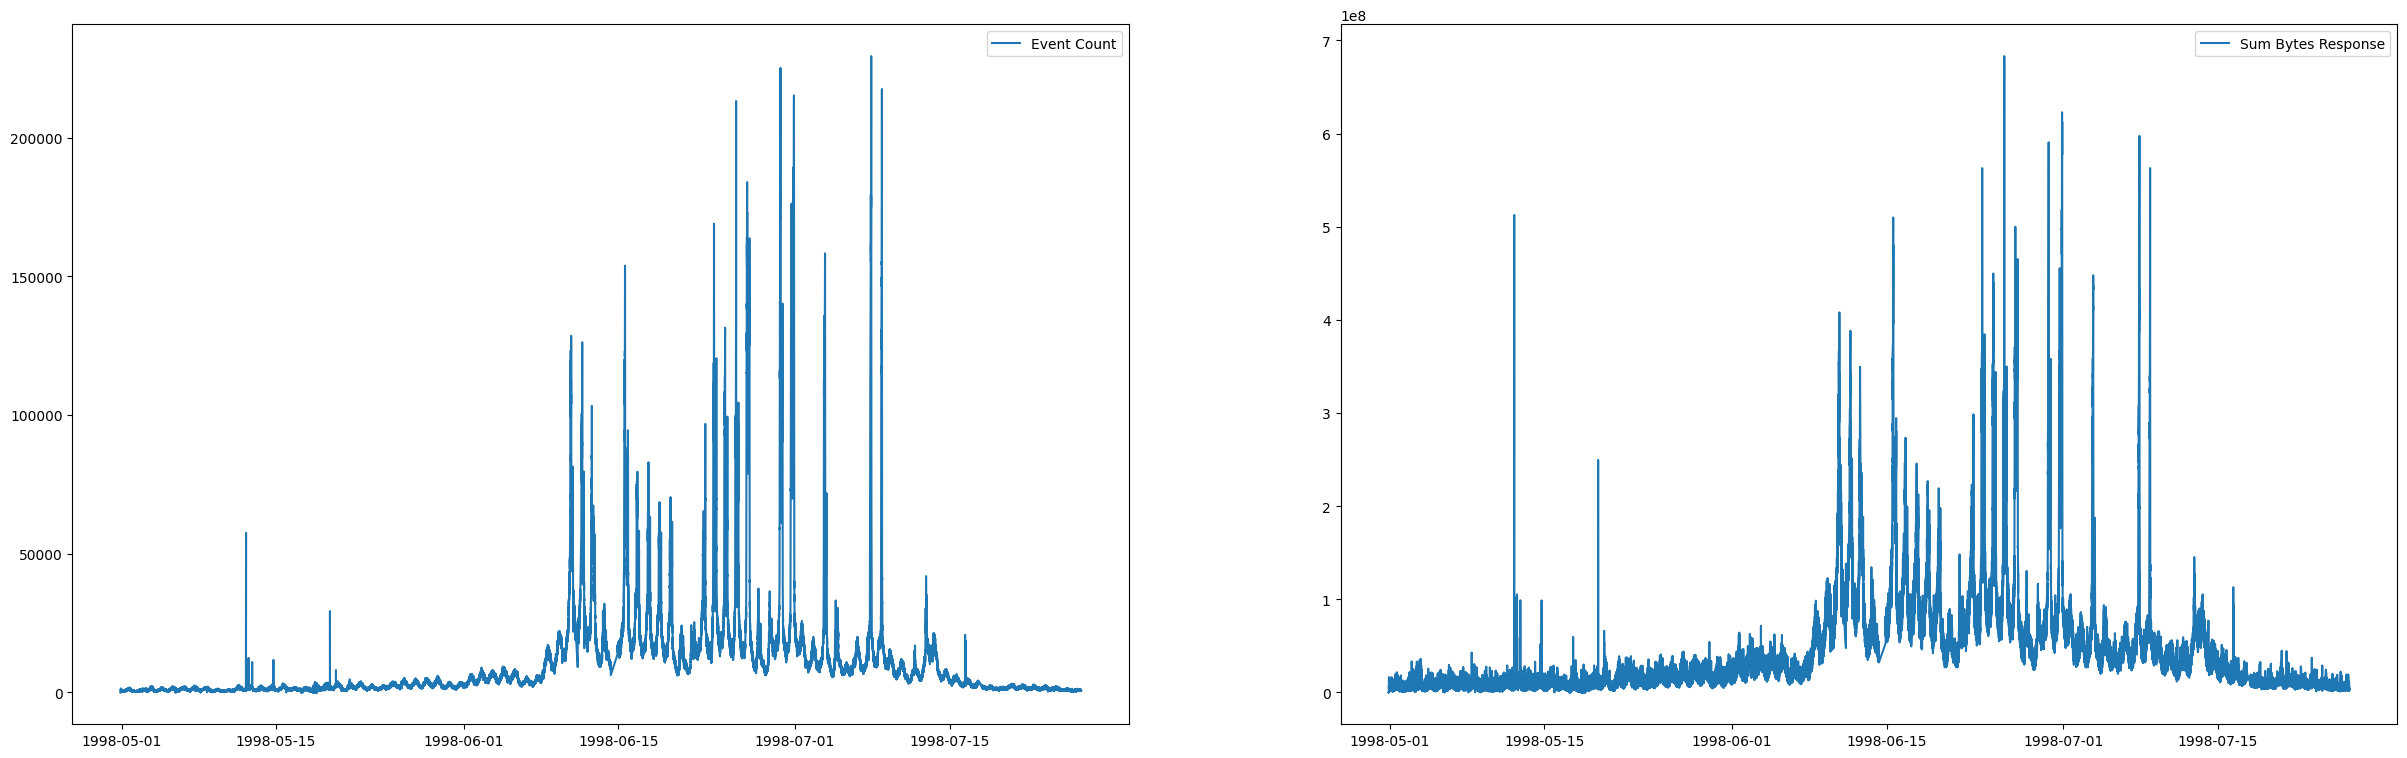

In [ ]:
plot_data(df)

In [ ]:
# Calculate the number of rows for each split
total_rows = df.shape[0]
train_rows = int(0.6 * total_rows)
valid_rows = int(0.2 * total_rows)
test_rows = total_rows - train_rows - valid_rows

# Split the dataset based on the calculated row counts
train_df = df[:train_rows]
valid_df = df[train_rows:train_rows+valid_rows]
test_df = df[train_rows+valid_rows:]

# Print the sizes of the sub-datasets
print("Total dataset: ", df.shape)
print("Training dataset size:", len(train_df))
print("Validation dataset size:", len(valid_df))
print("Test dataset size:", len(test_df))
print("total dataset: ", len(train_df) +  len(valid_df) + len(test_df))

Total dataset:  (123653, 4)
Training dataset size: 74191
Validation dataset size: 24730
Test dataset size: 24732
total dataset:  123653


In [ ]:
test_df['event_time'] = pd.to_datetime(test_df['event_time'])
test_df.head()

<ipython-input-7-07ed111dd8f9>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['event_time'] = pd.to_datetime(test_df['event_time'])


,event_time,event_count,sum_bytes,num_match_event
98921,1998-07-09 10:39:00,9340,40775221,0
98922,1998-07-09 10:40:00,9926,43813791,0
98923,1998-07-09 10:41:00,10295,37968735,0
98924,1998-07-09 10:42:00,9443,33659679,0
98925,1998-07-09 10:43:00,9579,47434221,0


In [ ]:
# Reset the index of the DataFrame
test_df = test_df.reset_index(drop=True)
test_df.head()

,event_time,event_count,sum_bytes,num_match_event
0,1998-07-09 10:39:00,9340,40775221,0
1,1998-07-09 10:40:00,9926,43813791,0
2,1998-07-09 10:41:00,10295,37968735,0
3,1998-07-09 10:42:00,9443,33659679,0
4,1998-07-09 10:43:00,9579,47434221,0


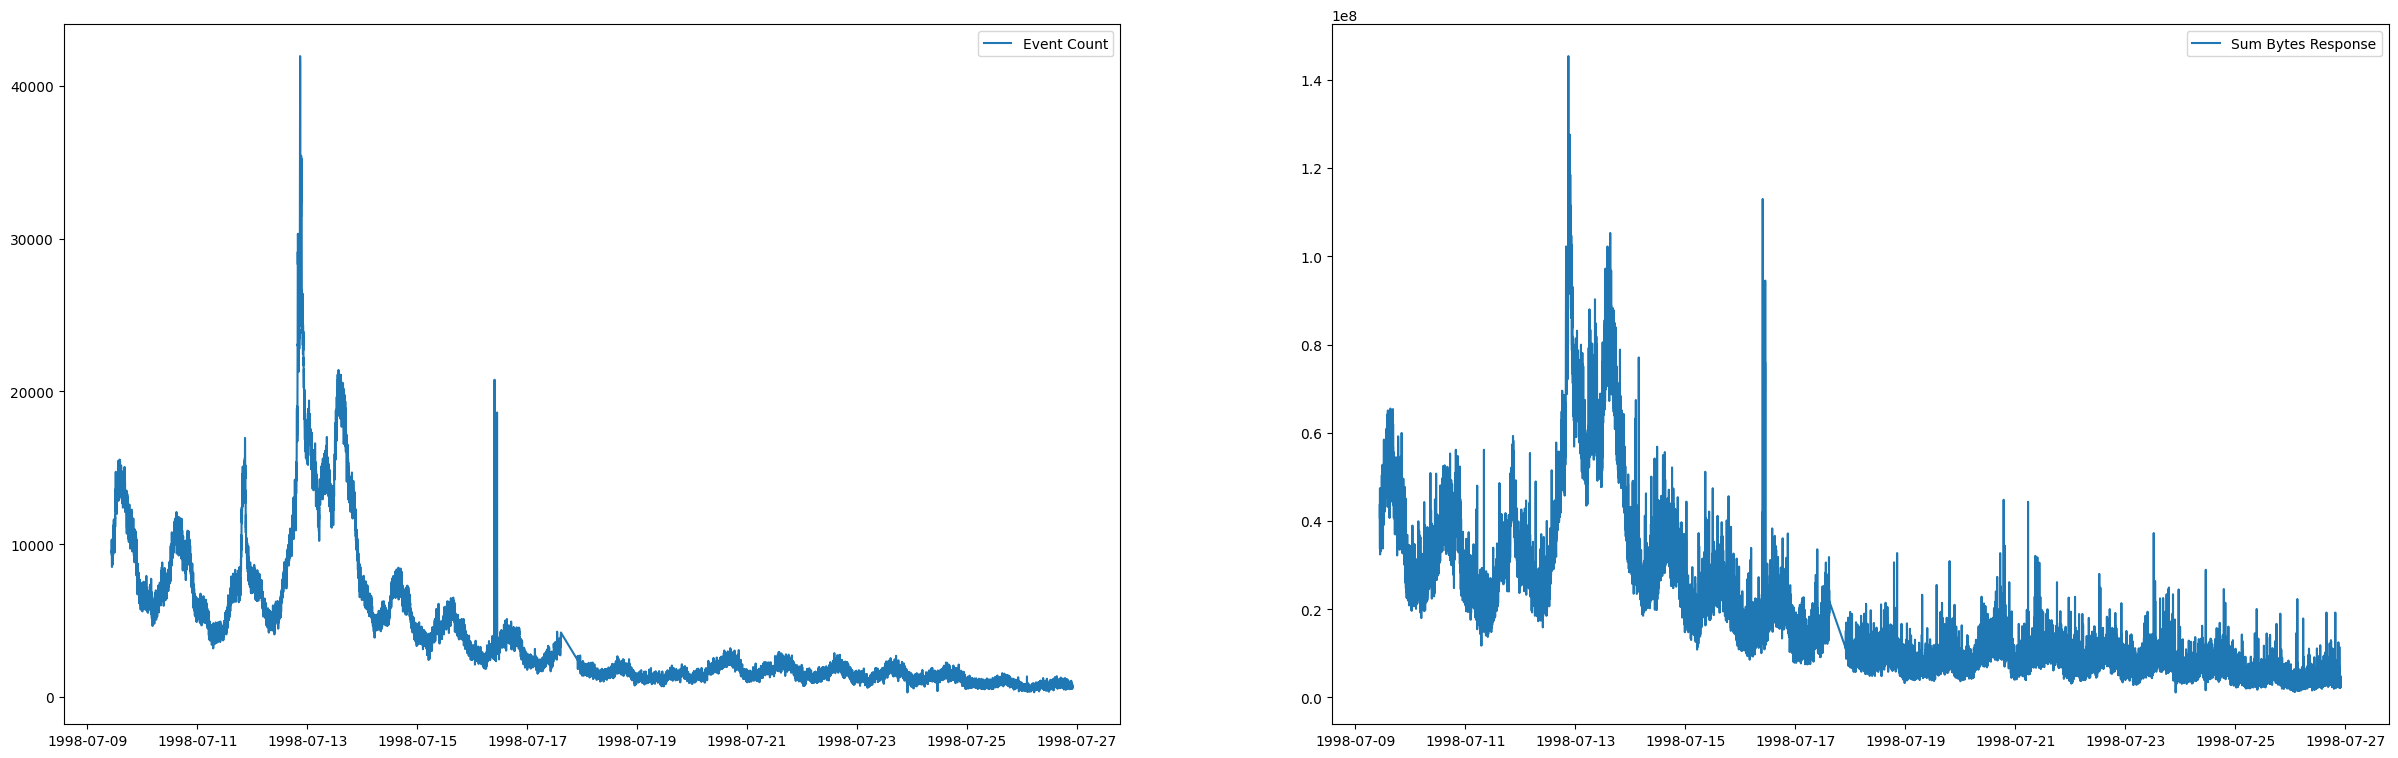

In [ ]:
plot_data(test_df)

In [ ]:
# Convert 'event_time' column to datetime type
test_df['event_time'] = pd.to_datetime(test_df['event_time'])

# Define the start and end times for the window
start_time = pd.to_datetime('1998-07-09 00:00:00')
end_time = pd.to_datetime('1998-07-17 00:00:00')

# Filter the DataFrame based on the window time
window_df = df.loc[(df['event_time'] >= start_time) & (df['event_time'] <= end_time)]

# Reset the index of the DataFrame
window_df = window_df.reset_index(drop=True)
window_df.head()

,event_time,event_count,sum_bytes,num_match_event
0,1998-07-09 00:00:00,17153,56182329,0
1,1998-07-09 00:01:00,17133,50105128,0
2,1998-07-09 00:02:00,15260,53759332,0
3,1998-07-09 00:03:00,15426,48404227,0
4,1998-07-09 00:04:00,14582,53364050,0


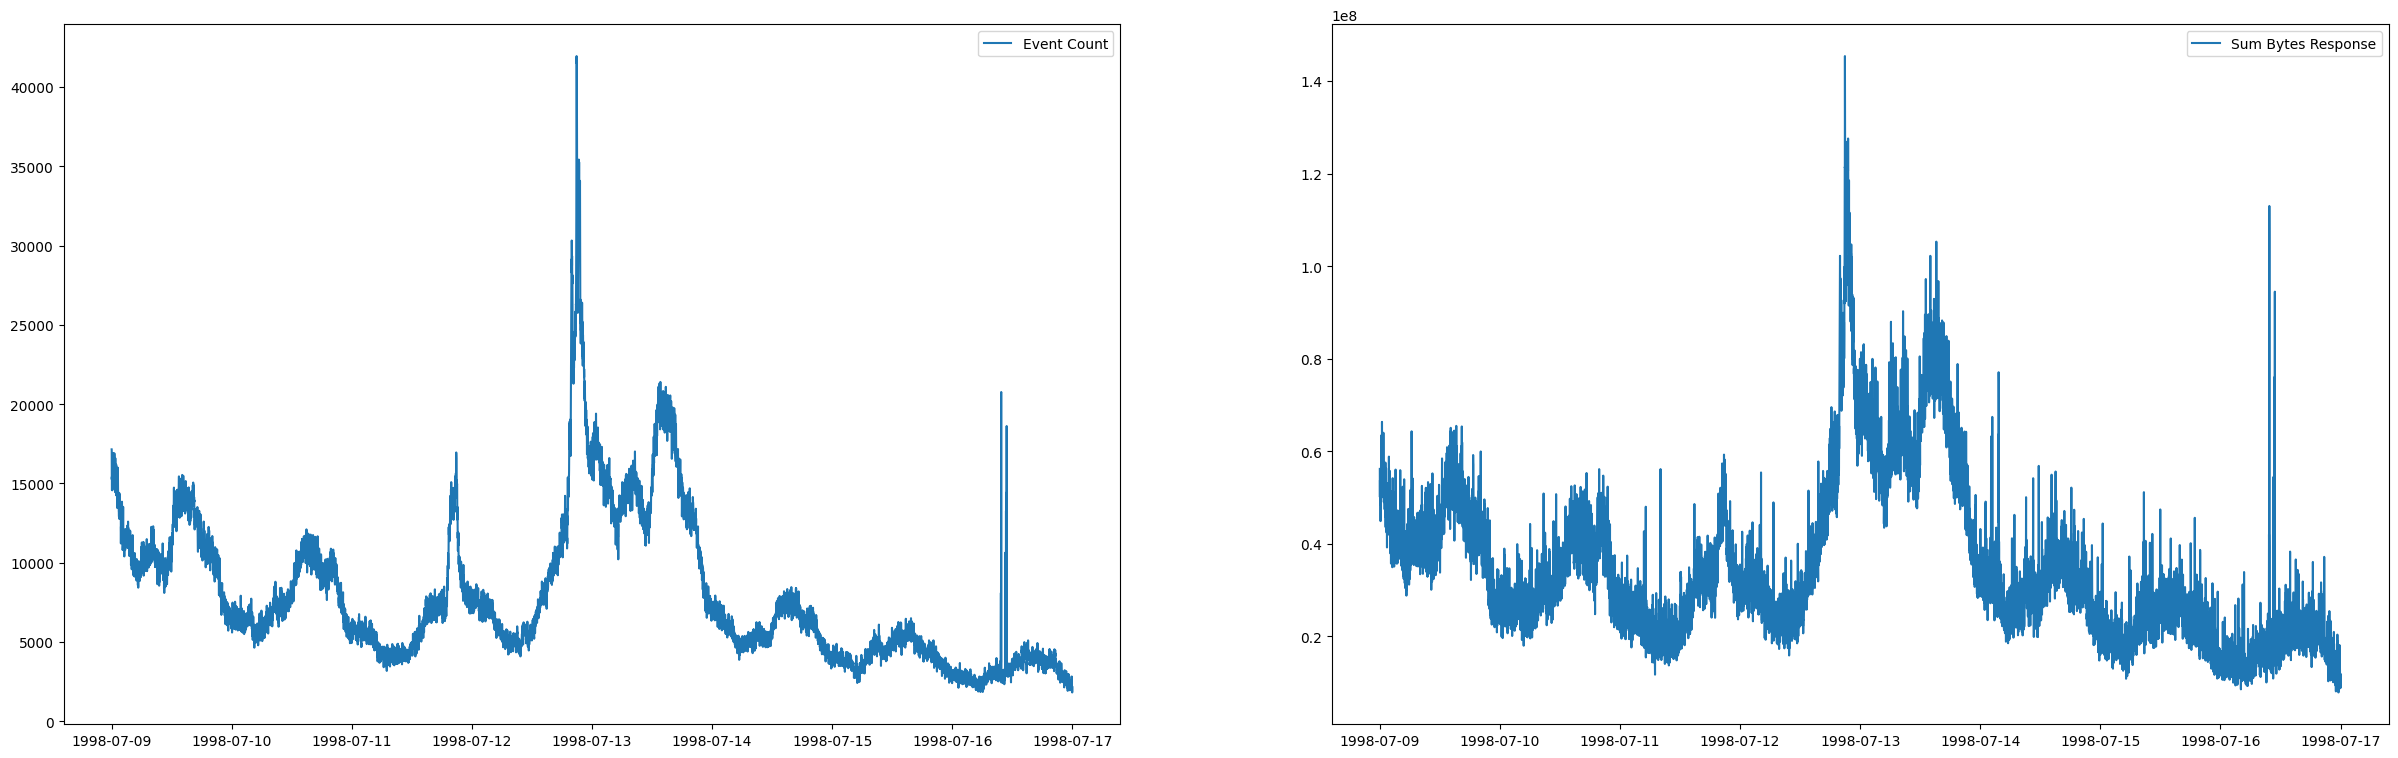

In [ ]:
plot_data(window_df)

In [ ]:
# Initialize a list to store the extracted times
change_times_scale_up = []
change_value_scale_up = []
change_times_scale_down = []
# Iterate over the rows of the DataFrame
for i in range(1, len(test_df)):
    prev_count = test_df.loc[i-1, 'event_count']
    curr_count = test_df.loc[i, 'event_count']
    threshold = int(curr_count/10000)*10000
    # Check for change from below 10000 to above 10000 or below 20000 to above 20000
    if (prev_count < threshold and curr_count > threshold):
        change_times_scale_up.append(test_df.loc[i, 'event_time'])
        change_value_scale_up.append(curr_count)
    if (prev_count > threshold and curr_count < threshold):
        change_times_scale_down.append(test_df.loc[i, 'event_time'])

# Print the extracted times
print(len(change_times_scale_up))
for idx, v in enumerate(change_value_scale_up):
    print(change_times_scale_up[idx], change_value_scale_up[idx])

139
1998-07-09 10:41:00 10295
1998-07-09 11:02:00 10024
1998-07-09 11:09:00 10190
1998-07-09 11:13:00 10368
1998-07-09 11:18:00 10222
1998-07-09 11:23:00 10344
1998-07-09 11:25:00 10688
1998-07-09 11:56:00 10241
1998-07-09 18:49:00 10001
1998-07-09 19:11:00 10635
1998-07-09 19:43:00 10068
1998-07-09 20:20:00 10444
1998-07-09 20:25:00 10127
1998-07-09 20:39:00 10739
1998-07-09 20:50:00 10248
1998-07-09 20:59:00 10076
1998-07-09 21:03:00 10171
1998-07-09 21:11:00 10024
1998-07-09 21:14:00 10347
1998-07-09 21:19:00 10480
1998-07-09 21:35:00 10291
1998-07-10 12:55:00 10778
1998-07-10 13:02:00 10047
1998-07-10 13:09:00 10025
1998-07-10 13:11:00 10247
1998-07-10 13:15:00 10081
1998-07-10 13:19:00 10146
1998-07-10 13:22:00 10168
1998-07-10 13:33:00 10187
1998-07-10 13:37:00 10644
1998-07-10 13:39:00 10140
1998-07-10 13:43:00 10732
1998-07-10 13:47:00 10315
1998-07-10 13:49:00 10065
1998-07-10 13:53:00 10367
1998-07-10 14:48:00 10382
1998-07-10 15:05:00 10621
1998-07-10 15:31:00 10824
1998-07-

In [ ]:
change_times_scale_up

In [ ]:
# Generate the time series with 1-minute intervals
time_series = pd.date_range(start=start_time, end=end_time, freq='1min')

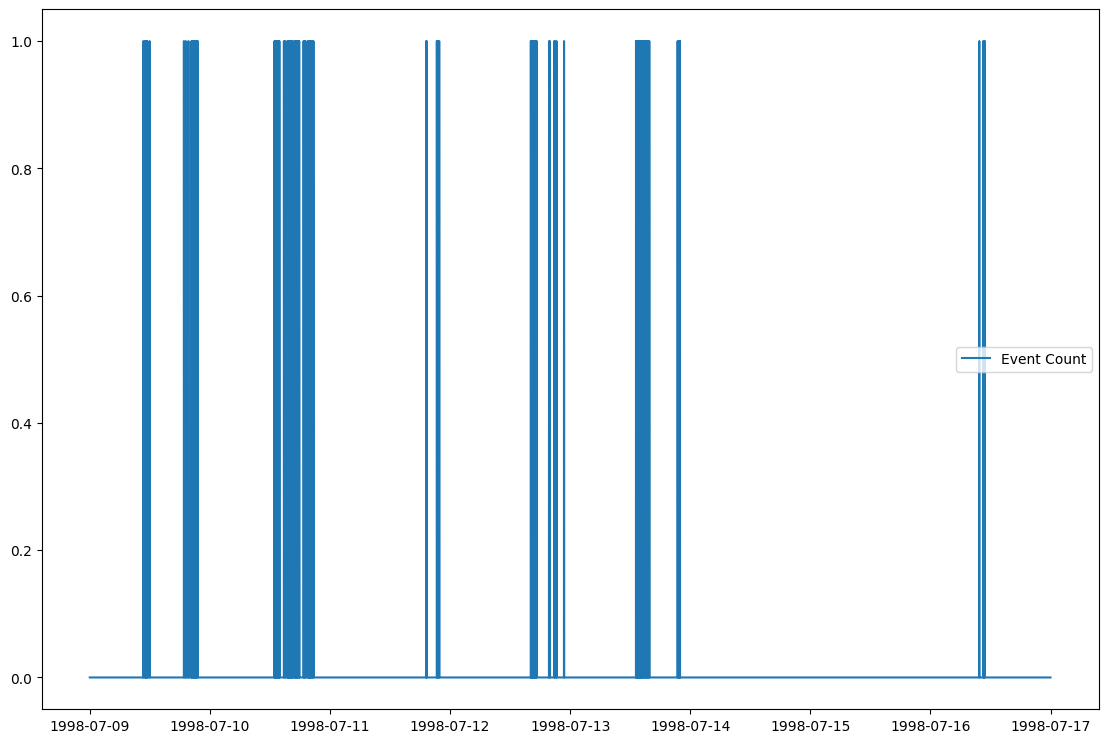

In [ ]:
y_values = []
for i in time_series:
  if i in change_times_scale_up:
    y_values.append(1)
  else: y_values.append(0)

fig = plt.figure(figsize=(30, 20))
ax1 = fig.add_subplot(2, 2, 1)  # Top left
ax1.plot(color='red', marker='o', markerfacecolor='blue')
ax1.plot(time_series, y_values, label='Event Count')#, color='blue')
ax1.legend()
# Display the plot
plt.show()

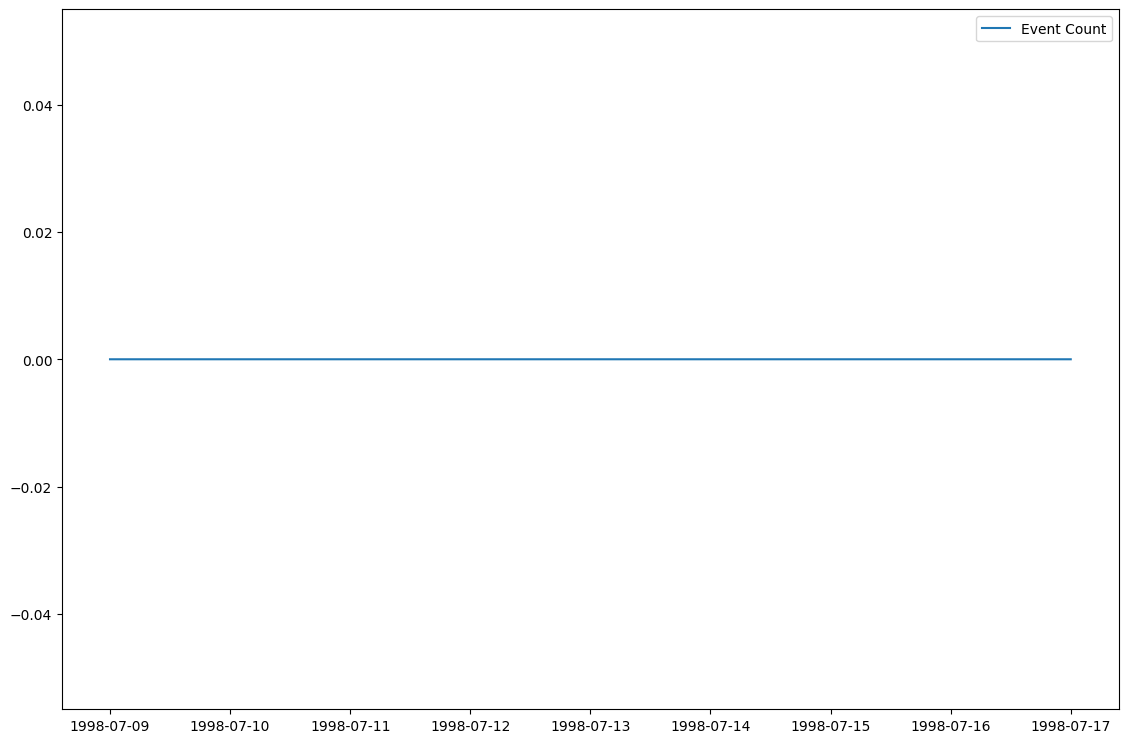

In [ ]:
y_values = []
for i in time_series:
  if i in change_times_scale_down:
    y_values.append(1)
  else: y_values.append(0)

fig = plt.figure(figsize=(30, 20))
ax1 = fig.add_subplot(2, 2, 1)  # Top left
ax1.plot(color='red', marker='o', markerfacecolor='blue')
ax1.plot(time_series, y_values, label='Event Count')#, color='blue')
ax1.legend()
# Display the plot
plt.show()